# Time Series Forecasting of Historical GME Data

[Daily GME Historical Dataset](https://www.kaggle.com/hananxx/gamestop-historical-stock-prices)

In [1]:
# Below loads all the preliminaries for the analysis.
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import simplefilter


# statistical modelling
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from scipy.optimize import minimize
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt   

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error


## Data Preprocessing

Setting the index_col parameter to zero and parsing the dates in the column ensures that the data can be considered time series.

In [2]:
data = pd.read_csv(r'D:\Documents\gamestop.csv', index_col=0, parse_dates=['date'])
data.sort_values(by='date', ascending='True')

,open_price,high_price,low_price,close_price,volume,adjclose_price
date,,,,,,
2002-02-13,9.625000,10.060000,9.525000,10.050000,19054000.0,6.766666
2002-02-14,10.175000,10.195000,9.925000,10.000000,2755400.0,6.733003
2002-02-15,10.000000,10.025000,9.850000,9.950000,2097400.0,6.699336
2002-02-19,9.900000,9.900000,9.375000,9.550000,1852600.0,6.430017
2002-02-20,9.600000,9.875000,9.525000,9.875000,1723200.0,6.648838
...,...,...,...,...,...,...
2021-01-22,42.590000,76.760002,42.320000,65.010002,196784300.0,65.010002
2021-01-25,96.730003,159.179993,61.130001,76.790001,177874000.0,76.790001
2021-01-26,88.559998,150.000000,80.199997,147.979996,178588000.0,147.979996


Python now recognises this dataset as data recorded over a period of time.

In [3]:
ts = data
ts = ts.sort_index() #Sorts to ascending by default
ts = ts[725:4000]
ts = ts.asfreq('M')
ts['adjclose_price'].interpolate(method='linear', inplace=True)

The dataset frequency has been changed from daily frequency to monthly frequency. This technique in data science is known as downsampling, and it's purpose is to reduce your sample size for analysis. Because the dataset is spread over the span of 19 years, predicting based on individual days is unnecessary for capturing the overall structure of the data. Graphs become difficult to read, and a larger quantity of computational processing power is required. Thus, monthly frequency is better suited for this analysis.

To account for the loss of data when converting from daily data to monthly data, [linear interpolation](https://www.toppr.com/guides/maths-formulas/linear-interpolation-formula/) was used to fill the missing data.

The chosen variable for the time series was the close price of GME stocks. In the stock market, close prices * finish *

In [4]:
ts = ts['adjclose_price'] #Select close price as the Series data

In [5]:
ts.describe()

count    157.000000
mean      20.652867
std        7.949016
min        6.426650
25%       14.819336
50%       18.149456
75%       26.757256
max       41.818676
Name: adjclose_price, dtype: float64

Standard deviation measure is low, which means that values in the dataset are not very spread out. This makes sense for time series because values will gradually change over time, so they will be closer together. 

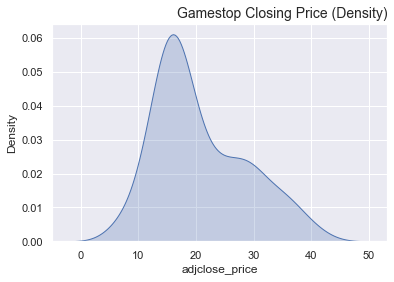

In [6]:
sns.set_style('darkgrid')
sns.kdeplot(ts, shade=True)
plt.title('Gamestop Closing Price (Density)', loc = 'right', fontsize=14)

plt.show()

Density appears to suggest a continuous probability distribution in the form of gamma distribution. For values that can potentially take on a wide range of values, gamma type distribution is likely. For example, [rainfall rates, queue wait times or life expectancy](https://study.com/academy/lesson/gamma-distribution-definition-equations-examples.html) can expect to see gamma type distribution.  

For time series forecasting, as the forecast progresses, elements of the series can take on a wide range of values. This distribution seems appropriate.

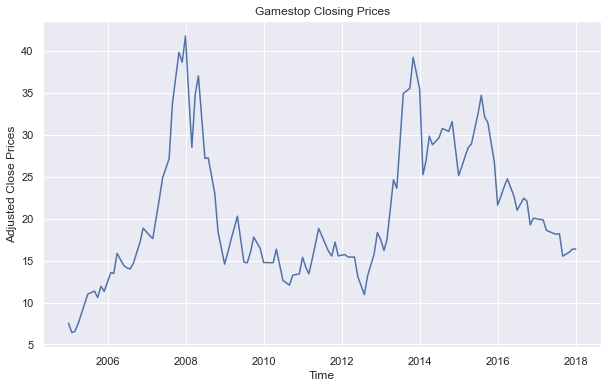

In [7]:
#line graph of closing price, allows for evaluation of seasonality/trend 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Adjusted Close Prices')
plt.plot(ts)
plt.title('Gamestop Closing Prices')
plt.show()


Beginning in 2006, the series measures with low closing prices, gradually increasing, and then peaking in 2008 before plummeting in 2009. Two years later, this same pattern repeats itself from 2011 to 2014. In the fourth quarter of 2015, the trend declines, echoing the same decline as 2009. 


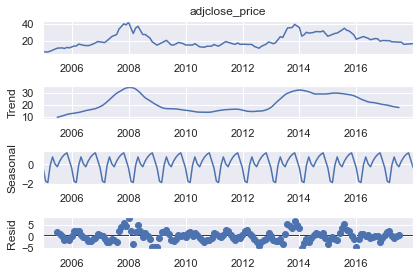

In [8]:
decomp = seasonal_decompose(ts)

decomp.plot()
plt.show()

**Seasonal Decomposition**

Seasonal decomposition describes the mathematical process of converting a single time series into multiple time series. Through this process, underlying features of the time series can be further evaluated:

Trend - Ascending and declining trend is present in this dataset. The trend decline from 2009 to 2014 appears to be steeper than the more gradual decline occuring from 2014 onwards. The peak close price for GME occurred in 2008, with a similar but slightly lower peak occuring in 2014.

Seasonality - In this dataset, the regular peaks that follow a consistent pattern, (2006-2009) and (2011-2014), imply that there is seasonality within this dataset. The decomposition plot appears to show additive seasonality, as indicated by the lack of variation in the patterns as time progresses.

## Statistical Methods for Time Series Forecasting

### Single Exponential Smoothing: 

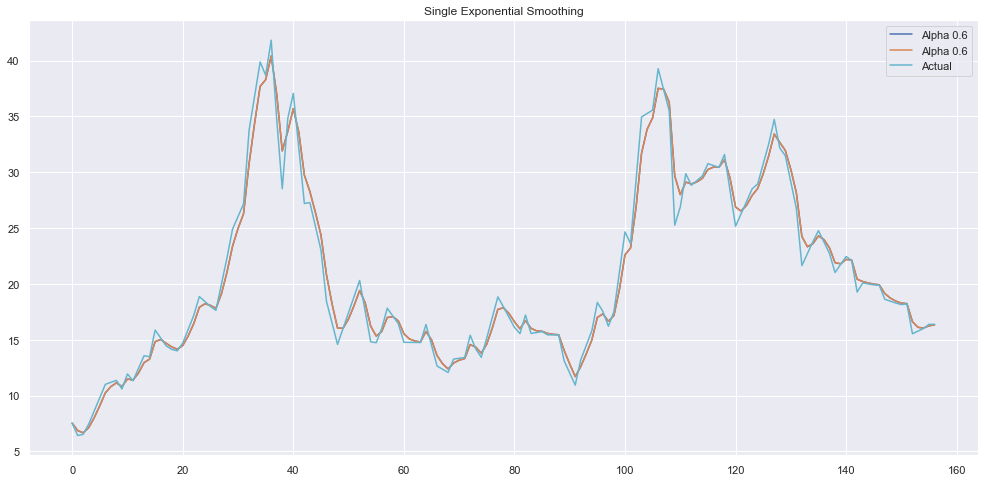

In [9]:
# Sourced from: https://gist.github.com/marcopeix/a9a37792661b57e581414735824e9e9d

def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title('Single Exponential Smoothing')
    plt.grid(True);

plot_exponential_smoothing(ts, [0.6, 0.6])

The alpha parameter functions as the smoothing factor. It decides roughly how well fitted the alpha line will fit to the line plotting the actual data. The higher the alpha parameter is tuned, the more stricter the fit of the alpha line is to the actual line. As shown above, at any alpha measurement, the SES method is incapable capturing the sharpest peaks and troughs in the dataset.

### Double Exponential Smoothing (Holt's Method): 

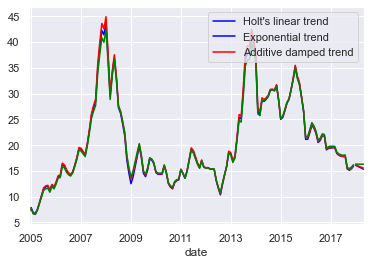

In [10]:
# Sourced from: https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html

fit1 = Holt(ts, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=True)
fcast1 = fit1.forecast(5).rename("Holt's linear trend")

fit2 = Holt(ts, exponential=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=True)
fcast2 = fit2.forecast(5).rename("Exponential trend")

fit3 = Holt(ts, damped_trend=True, initialization_method="estimated").fit(smoothing_level=0.8, smoothing_trend=0.2, optimized=True)
fcast3 = fit3.forecast(5).rename("Additive damped trend")

fit1.fittedvalues.plot(color='blue')
fcast1.plot(color='blue', legend=True)

fit2.fittedvalues.plot(color='red')
fcast2.plot(color='red', legend=True)

fit3.fittedvalues.plot(color='green')
fcast3.plot(color='green', legend=True)

plt.show()

Now, the beta parameters are incorporated into the exponential smoothing process, resulting in Double Exponential Smoothing. While the alpha parameters (indicated by the 'smoothing_level' parameter) are maintained for the smoothing factor, the beta parameter (indicated by the 'smoothing_trend' parameter) introduces smoothing for trends in the time series data. As shown by the plot, this allows for more accurate fitting across sharp peaks and troughs. 

### Triple Exponential Smoothing (Holt's-Winter Method)

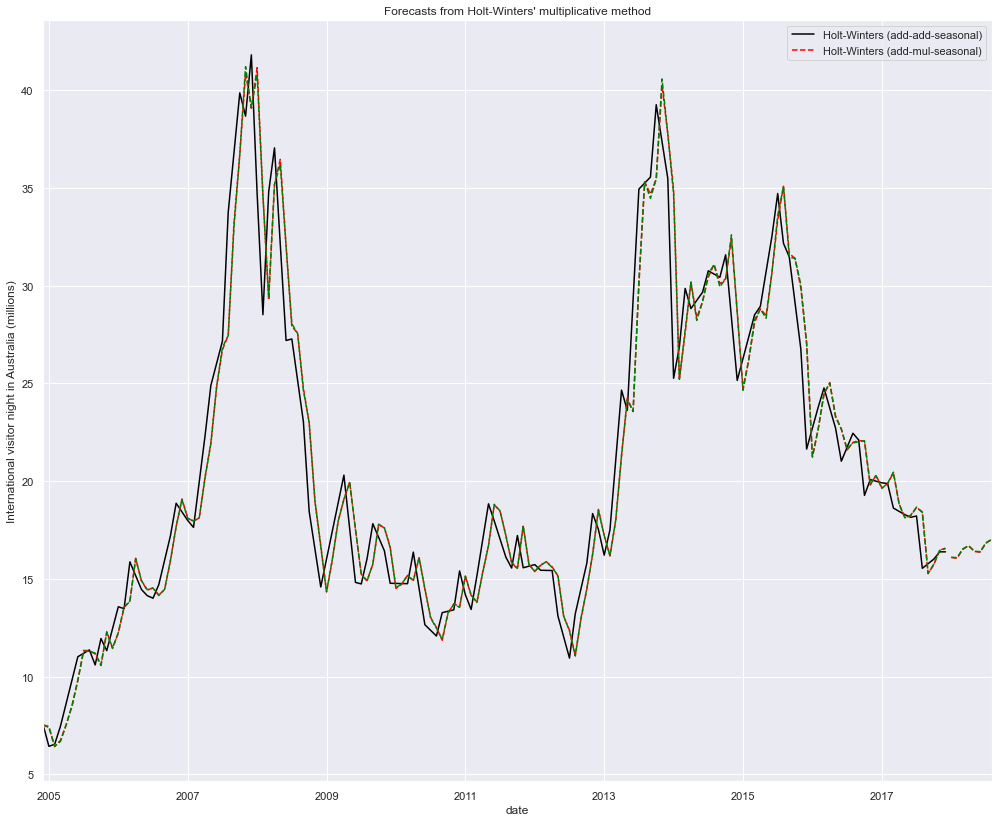


Results: 



,Additive,Multiplicative,Additive Dam,Multiplica Dam
$\alpha$,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
$\beta$,0.000000e+00,0.000000e+00,1.479767e-01,1.506596e-01
$\phi$,NaN,NaN,8.000000e-01,8.000000e-01
$\gamma$,1.415442e-10,2.393820e-11,1.157177e-10,2.776200e-10
$l_0$,2.242057e+00,2.236361e+00,2.229091e+00,2.334881e+00
$b_0$,6.594960e-03,6.505351e-03,3.017448e-02,2.385243e-02
SSE,7.416216e+02,7.357452e+02,7.191518e+02,7.131993e+02


In [11]:
fit1 = ExponentialSmoothing(ts, seasonal_periods=4, trend='add', seasonal='add', use_boxcox=True, initialization_method="estimated").fit()
fit2 = ExponentialSmoothing(ts, seasonal_periods=4, trend='add', seasonal='mul', use_boxcox=True, initialization_method="estimated").fit()
fit3 = ExponentialSmoothing(ts, seasonal_periods=4, trend='add', seasonal='add', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
fit4 = ExponentialSmoothing(ts, seasonal_periods=4, trend='add', seasonal='mul', damped_trend=True, use_boxcox=True, initialization_method="estimated").fit()
results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]
results["Multiplicative"] = [fit2.params[p] for p in params] + [fit2.sse]
results["Additive Dam"]   = [fit3.params[p] for p in params] + [fit3.sse]
results["Multiplica Dam"] = [fit4.params[p] for p in params] + [fit4.sse]

ax = ts.plot(figsize=(17, 14), marker='', color='black', title="Forecasts from Holt-Winters' multiplicative method" )
ax.set_ylabel("International visitor night in Australia (millions)")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')
fit2.fittedvalues.plot(ax=ax, style='--', color='green')

fit1.forecast(8).rename('Holt-Winters (add-add-seasonal)').plot(ax=ax, style='--', marker='', color='red', legend=True)
fit2.forecast(8).rename('Holt-Winters (add-mul-seasonal)').plot(ax=ax, style='--', marker='', color='green', legend=True)

plt.show()
print("\nResults: \n")
results

Triple Exponential Seasoning introduces the gamma parameter to the technique. This parameter allows for fitting to time series data with seasonality present within it's structure. The statsmodel library enables users to use the most optimised parameters for fitting the trend and seasonality lines, as determined by the library. 

---------------------------------------------------

### AutoRegressive (AR) Model

#### Non-Differenced Values

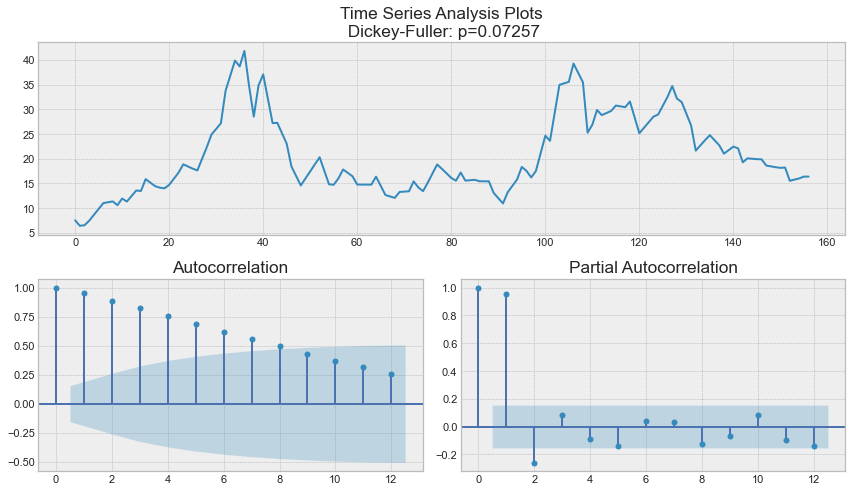

In [43]:
# plots normal time series for Dickey-Fuller Test. Sourced from: 

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

# lags parameter determines the amount of points to plot for Autocorrelation plots
tsplot(ts.values, lags=12)

In [58]:
adf_result=adfuller(ts.values, autolag='AIC')
#to help you, we added the names of every value
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],adf_result))
#tsplot(data_diff.values[1:], lags=12)

{'adf': -2.7085242774945435,
 'pvalue': 0.07257477678593521,
 'usedlag': 4,
 'nobs': 152,
 'criticalvalues': {'1%': -3.474120870218417,
  '5%': -2.880749791423677,
  '10%': -2.5770126333102494},
 'icbest': 633.7057414639812}

predicted=25.353518, expected=26.274093
predicted=25.935382, expected=27.392350
predicted=27.601423, expected=28.510607
predicted=27.587224, expected=28.946220
predicted=27.664085, expected=30.738747
predicted=30.956316, expected=32.531273
predicted=32.111614, expected=34.719707
predicted=33.516383, expected=32.167797
predicted=30.988170, expected=31.477779
predicted=31.450423, expected=29.117517
predicted=27.398083, expected=26.757256
predicted=25.378495, expected=21.640425
predicted=20.089539, expected=22.713183
predicted=23.281094, expected=23.785942
predicted=22.724439, expected=24.768423
predicted=23.774111, expected=23.741934
predicted=23.314452, expected=22.715445
predicted=22.597137, expected=21.019987
predicted=19.695702, expected=21.735678
predicted=21.599118, expected=22.451368
predicted=22.559136, expected=22.107035
predicted=21.225289, expected=19.270538
predicted=18.021326, expected=20.078743
predicted=20.686883, expected=19.997419
predicted=19.733032, expected=19.916096


C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


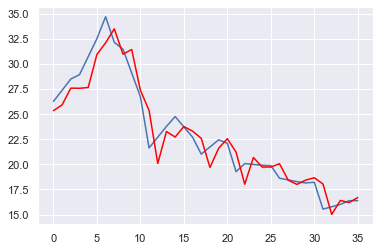

In [45]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

X = ts.values
ar_train, ar_test = X[0:120], X[121:157]
# train autoregression
window = 12
model = AutoReg(ar_train, lags=12)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = ar_train[len(ar_train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(ar_test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = ar_test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(ar_test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(ar_test)
plt.plot(predictions, color='red')
plt.show()

#### Differenced Values

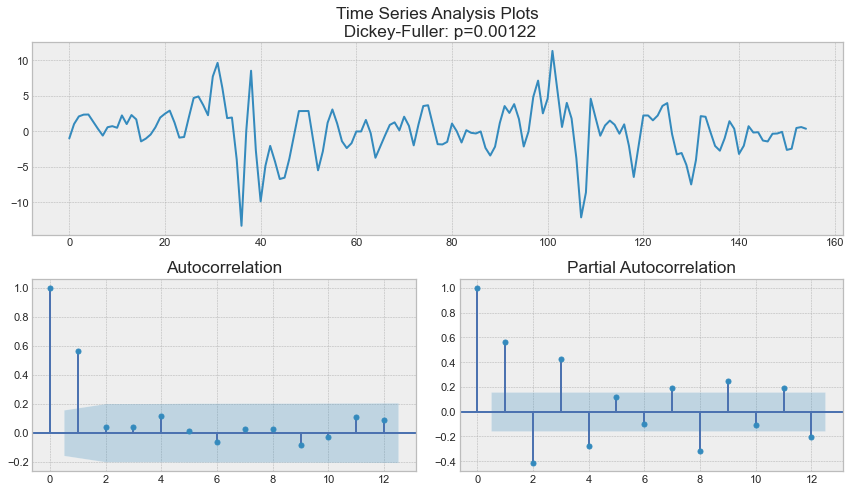

In [64]:
# Augmented Dickey-Fuller Test

ts_diff = ts.diff(2) # Difference data by two
ts_diff = ts_diff.dropna()

# plots normal time series for Dickey-Fuller Test
tsplot(ts_diff.values, lags=12)

In [59]:
adf_result=adfuller(ts_diff.values, autolag='AIC')
#to help you, we added the names of every value
dict(zip(['adf', 'pvalue', 'usedlag', 'nobs', 'critical' 'values', 'icbest'],adf_result))
#tsplot(data_diff.values[1:], lags=12)

{'adf': -4.039339437051821,
 'pvalue': 0.001217963895551515,
 'usedlag': 13,
 'nobs': 141,
 'criticalvalues': {'1%': -3.4776006742422374,
  '5%': -2.882265832283648,
  '10%': -2.5778219289774156},
 'icbest': 641.7264286092791}

Differencing the data by 2 results in the lowest p-value that is > 0. As shown in the ACF plot, most of the points are now within the same blue area, and are measuring close to 0.0. This means that the trend from the data has been removed.

predicted=2.895156, expected=2.236514
predicted=1.182367, expected=1.553871
predicted=-0.571033, expected=2.228140
predicted=2.898261, expected=3.585052
predicted=2.516826, expected=3.980961
predicted=1.835467, expected=-0.363476
predicted=-2.362285, expected=-3.241928
predicted=0.000600, expected=-3.050280
predicted=-2.555447, expected=-4.720524
predicted=-3.700809, expected=-7.477093
predicted=-5.433896, expected=-4.044072
predicted=1.431417, expected=2.145517
predicted=1.543035, expected=2.055240
predicted=-0.595392, expected=-0.044008
predicted=0.432693, expected=-2.052979
predicted=-1.670327, expected=-2.721947
predicted=-1.228912, expected=-0.979767
predicted=-0.127479, expected=1.431381
predicted=2.578081, expected=0.371357
predicted=-1.560783, expected=-3.180830
predicted=-2.769662, expected=-2.028292
predicted=0.692165, expected=0.726881
predicted=0.995860, expected=-0.162647
predicted=-0.760324, expected=-0.121983
predicted=0.923395, expected=-1.294624
predicted=-1.969366, ex

C:\Users\lucap\miniconda3\envs\Jupyterlab\lib\site-packages\statsmodels\tsa\ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,


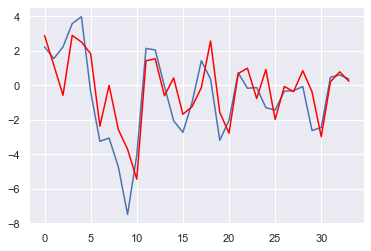

In [60]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

X = ts_diff.values
ar_train, ar_test = X[0:120], X[121:157]
# train autoregression
window = 12
model = AutoReg(ar_train, lags=12)
model_fit = model.fit()
coef = model_fit.params

# walk forward over time steps in test
history = ar_train[len(ar_train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(ar_test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = ar_test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(ar_test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.plot(ar_test)
plt.plot(predictions, color='red')
plt.show()

The statsmodel autoregression function was used to construct the AR model. To create the model, values from the time series were split into training and testing. Because this is a statistical model and we are using univariate time series, only an X variable is neccessary. 

The windows and lag have been set to 12. The window may be lower than the lag however, the lag cannot be lower than the window. The lowest RMSE score that can was achieved in this analysis is 1.575 for both the non-differenced and differenced model. Looking at the plots, the accuracy of the prediction line (red) for predicting the test line (blue) are close. 

The Augmented Dickey-Fuller Test is a statistical test used for evaluating whether stationarity is present within time series data. This is crucial for any Autoregressive model (AR). The purpose of the test is to determine whether time series is stationary or not.

**ADF Statistic: Non-Differenced = -2.708 // Differenced = -4.039**

The more negative this statistic, the more likely the time series can be considered stationary. A value of -2 for the non-differenced time series indicates a decently strong presence of stationarity. However, with differencing, the statistic falls to -4.039 which suggests an even stronger presence of stationarity in the differenced data. 

**P-value: Non-Differenced = 0.07257 // Differenced = 0.001**

The non-differenced values fall slightly higher than the statistical significance metric (0.05). This is an indication that we cannot reject the null hypothesis therefore, even if the ADF statistic is negative, we cannot reject the null hypothesis and must assume the data is non-stationary. For the differenced dataset, the p-value falls extremely low with a difference of 1 between the original values and the lagged values. For this value, we can most certainly reject the null hypothesis, which means we can consider the time series stationary. 

**Test RMSE: 1.525**

This is the Root Mean Square Error for both models. This is the designated loss function for this model. The closer to 0, the more accurate the models predictions are to the expected values. Judging by the actual prediction and expected values, the model is mostly accurate.

It can be concluded that without differencing, the time series is non-stationary due to it's p-values and significantly higher ADF statistic. However, both models are adequete in their predictions. 

### Moving Average (MA) Model

In [ ]:
#SMA Taken from: https://gist.github.com/RohanTrix/b2301db8b63dcd9fe0b13a271ac4080c

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Simple Moving Average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        rmse = np.sqrt(((series - window) ** 2).mean())
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        #plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        #plt.plot(lower_bound, 'r--')
        #print("Mean Absolute Error: ", mae, "\n")    #uncomment to see MAE and RMSE
        #print("Root Mean Squared Error", rmse, "\n")
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(ts, 5, plot_intervals=True)

In [ ]:
#Function taken from: https://gist.github.com/sohan-py/ab148e7716e1964be2fda42c132c2699#file-ema-py

def calculate_ema(prices, days, smoothing=14.5):
    ema = [sum(prices[:days]) / days]
    for price in prices[days:]:
        ema.append((price * (smoothing / (1 + days))) + ema[-1] * (1 - (smoothing / (1 + days))))
    return ema


ema = calculate_ema(ts, 10)

price_X = np.arange(ts.shape[0]) # Creates array [0, 1, 2, 3, ..., df.shape[0]]
ema_X = np.arange(10, ts.shape[0]+1) # Creates array [10, 11, 12, 13, ..., df.shape[0]+1]
                                     # We start at 10, because we use the first 10 values to calculate the SMA,
                                     # then we calculate EMA form the 11th valu
plt.figure(figsize=(17,8))
plt.title('Exponential Moving Average\n Window Size = 10')        
plt.xlabel('Days')
plt.ylabel('Price')
plt.plot(price_X, ts, label='Closing Prices')
plt.plot(ema_X, ema, label='EMA', color = 'g')
plt.legend()
#print(mean_absolute_error(ema_X, ema)) #Unsure whether MAE is necessary
plt.show()

### SARIMA Model

In [ ]:
import pmdarima as pm
from pmdarima.arima import auto_arima

In [ ]:
# Train Test Split Index
train_size = 0.8
split_idx = round(len(ts)* train_size)
split_idx

# Split
arima_train = ts.iloc[:split_idx]
arima_test = ts.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(15,10))
kws = dict(marker='o')
plt.plot(arima_train, label='Train', **kws)
plt.plot(arima_test, label='Test', **kws)
ax.legend(bbox_to_anchor=[1,1]);

In [ ]:
arima_model = auto_arima(arima_train, start_p=0, start_q=0,
                             max_p=5, max_q=5, m=12,
                             start_P=0, seasonal=True, stationary = False,
                             d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise
arima_model.summary()

In [ ]:
arima_model.plot_diagnostics()

In [ ]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 30), index=arima_test.index)

prediction.columns = ['predicted_close_price']

print(prediction)

In [ ]:
#forecasting with ARIMA

plt.figure(figsize=(12, 9))
plt.title("Forecast vs Actuals")
plt.plot(arima_train, label = "Training")
plt.plot(arima_test, label = "Test")
plt.plot(prediction, label = "Predicted")
plt.legend(loc = "upper left")
plt.show()

In [ ]:
# Forecast
n_periods = 31
fc, confint = arima_model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(ts.values), len(ts.values)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.figure(figsize=(12, 9))
plt.plot(ts.values)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of Gamestop Close Price")
plt.show()

In [ ]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-arima_test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, arima_test.values)

## Machine Learning Methods for Time Series Analysis

### K Neighbours Regression

In [ ]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import (
    ExpandingWindowSplitter,
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.compose import (
    EnsembleForecaster,
    MultiplexForecaster,
    TransformedTargetForecaster,
    make_reduction,
)

from sktime.performance_metrics.forecasting import (
    MeanAbsolutePercentageError,
    mean_absolute_percentage_error,
)

from sklearn.neighbors import KNeighborsRegressor
from sktime.utils.plotting import plot_series

In [ ]:
y_train, y_test = temporal_train_test_split(ts, test_size=36)
print(y_train.shape[0], y_test.shape[0])

In [ ]:
fh = ForecastingHorizon(y_test.index, is_relative=False)
fh

In [ ]:
regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
print("Mean Absolute Error: ", mean_absolute_error(y_pred, y_test))
print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(y_pred, y_test))
print("Mean Squared Error: ", mean_squared_error(y_pred, y_test))

### Gradient Boosted Trees for Time Series Forecasting

In [ ]:
from xgboost import XGBRegressor
 
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(np.asarray([testX]))
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # fit model on history and make a prediction
        yhat = xgboost_forecast(history, testX)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
    # estimate prediction error
    error = mean_absolute_error(test[:, -1], predictions)
    #mse = mean_squared_error(test[:, -1], predictions) #Not functioning as intended
    return error, test[:, -1], predictions
 
# load the dataset
series = pd.read_csv('D:\Documents\gamestop.csv', header=0, index_col=0)
values = ts.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=12)
# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae)
# plot expected vs preducted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()